In [159]:
!pip install mpl_toolkits

ERROR: Could not find a version that satisfies the requirement mpl_toolkits (from versions: none)
ERROR: No matching distribution found for mpl_toolkits


<module 'PIL.Image' from '/Users/aseem/opt/anaconda3/envs/privacy_env/lib/python3.9/site-packages/PIL/Image.py'>

In [160]:
from mpl_toolkits.axes_grid1 import ImageGrid

In [1]:
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import random
import argparse
from PIL import Image
from PIL.PngImagePlugin import PngInfo

In [2]:
import os, sys

## Functions ##

In [ ]:
220*3

In [3]:
def show(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.axis("off")
    plt.imshow(im)
    plt.show()

In [4]:
def cluster(im, n_clusters):
    im = im.reshape((im.shape[0] * im.shape[1], 3))
    km = KMeans(n_clusters=n_clusters, random_state=0)
    km.fit(im)

    counts = {}
    reps = km.cluster_centers_

    # count colors per label
    for i in range(len(im)):
        if km.labels_[i] not in counts:
            counts[km.labels_[i]] = {}
        rgb = tuple(im[i])
        if rgb not in counts[km.labels_[i]]:
            counts[km.labels_[i]][rgb] = 0
        counts[km.labels_[i]][rgb] += 1

    # remap representative to most prominent color for ea label
    for label, hist in counts.items():
        flat = sorted(hist.items(), key=lambda x: x[1], reverse=True)
        col = 0
        # # Soften Edges
        # if sum(flat[0][0])>600:
        #     reps[label] = reps[label-1]
        # else:
        reps[label] = flat[0][0]
    # print(reps)
    return km.cluster_centers_, km.labels_

In [5]:
def remap_colors(im, reps, labels):
    orig_shape = im.shape
    im = im.reshape((im.shape[0] * im.shape[1], 3))
    for i in range(len(im)):
        im[i] = reps[labels[i]]
    return im.reshape(orig_shape)

In [6]:
def find_contours(im, reps, min_area): 
    contours = []
    for rep in reps:
        mask = cv2.inRange(im, rep-1, rep+1)
        # show(mask)
        conts, _ = cv2.findContours(
            mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        for cont in conts:
            area = cv2.contourArea(cont)
            if area >= min_area:
                contours.append((area, cont, rep))
    contours.sort(key=lambda x: x[0], reverse=True)
    return contours

In [7]:
def get_crops(image):
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    crop_images = []
    for (x, y, w, h) in faces:
        crop_images.append(image[y:y+h, x:x+w])
    return faces , crop_images

In [ ]:
"""argp = argparse.ArgumentParser(description='Cutout filter.')
argp.add_argument('-in-file', type=str, required=True)
argp.add_argument(
    '-out-file', type=str, 
    help='If empty output is displayed with pyplot.')
argp.add_argument(
    '-n-clusters', type=int, default=3,
    help='Number of colors.')
argp.add_argument(
    '-blur-kernel', type=int, default=5,
    help='The size of the blur kernel.')
argp.add_argument(
    '-min-area', type=int, default=50,
    help='Contours with areas smaller than this are dropped.')
argp.add_argument(
    '-poly-epsilon', type=float, default=10,
    help='Maximum distance between original contour and its drawing.')
argp.add_argument(
    '-quiet', action='store_true', default=False,
    help='Do not print progress.')
argp.add_argument(
    '-final-blur', action='store_true', default=False,
    help='3 pixel blur on the output to clean up the jaggies.')
args = argp.parse_args()

if args.blur_kernel % 2 != 1:
    print('-blur-kernel must be an odd number')
    return 1

if args.min_area < 1:
    print('-min-area must be at least 1')
    return 1

if not args.quiet:
    print(f'Reading file {args.in_file}...')"""

## Param Configs

In [ ]:
class Args:
    in_file="KSJ.jpg"
    out_file = "./outtest.png"
    blur_kernel = 9
    n_clusters = 6
    min_area = 500
    poly_epsilon = 10
    quiet = False
    final_blur = False
    def __init__(self):
        print("Created args")
    def get_metadata(self):
        return {"blur_kernel" : self.blur_kernel,
                "n_clusters" : self.n_clusters,
                "min_area" : self.min_area,
                "poly_epsilon" : self.poly_epsilon,
                "quiet" : self.quiet,
                "final_blur" : self.final_blur
               }
            
args = Args()
metadata= args.get_metadata()

In [ ]:
orig = cv2.imread(args.in_file)
im = orig.copy()
# show(im)

ret_tup = get_crops(im)
im = ret_tup[1][0]
x,y,w,h = ret_tup[0][0]

show(im)

if not args.quiet:
    print(f'Blurring with size {args.blur_kernel}...')

im = cv2.GaussianBlur(im, (args.blur_kernel, args.blur_kernel), 0)
# show(im)

if not args.quiet:
    print(f'Clustering around {args.n_clusters} colors...')

reps, labels = cluster(im, args.n_clusters)

if not args.quiet:
    print('Remapping image to representative colors...')

im = remap_colors(im, reps, labels)
# show(im)

if not args.quiet:
    print(f'Finding contours with area gte {args.min_area}...')

contours = find_contours(im, reps, args.min_area)

if not args.quiet:
    print(f'Drawing...')

canvas = np.zeros(im.shape, np.uint8)
show(im)
for area, cont, rep in contours:
    approx = cv2.approxPolyDP(cont, args.poly_epsilon, True)
    cv2.drawContours(canvas, [approx], -1, rep, -1)

if args.final_blur:
    canvas = cv2.GaussianBlur(canvas, (3, 3), 0)
    
if not args.quiet:
    print(f'Drawing Complete')

orig[y:y+h, x:x+w] = canvas
# if args.out_file is None:
print(metadata)
show(canvas)
# else:
#     cv2.imwrite(args.out_file, canvas)

In [27]:
print(metadata)
show(orig)
cv2.imwrite(args.out_file, orig)

NameError: name 'metadata' is not defined

In [28]:
def merge_images(file1, file2):
    """Merge two images into one, displayed side by side
    :param file1: path to first image file
    :param file2: path to second image file
    :return: the merged Image object
    """
    image1 = Image.open(file1)
    image2 = Image.open(file2)

    (width1, height1) = image1.size
    (width2, height2) = image2.size

    result_width = width1 + width2
    result_height = max(height1, height2)

    result = Image.new('RGB', (result_width, result_height))
    result.paste(im=image1, box=(0, 0))
    result.paste(im=image2, box=(width1, 0))
    return result

In [ ]:
stitch= merge_images(args.in_file,args.out_file)

In [ ]:
plt.imshow(stitch)

In [ ]:
stitch.save("./compare.png")

## Multiface

In [ ]:
class Args:
    in_file="Batman.jpg"
    out_file = "outs/"+in_file.split('.')[0]+".png"
    blur_kernel = 5
    n_clusters = 3
    min_area = 100
    poly_epsilon = 1
    quiet = True
    final_blur = False
    def __init__(self):
        print("Created args")
    def get_metadata(self):
        return {"blur_kernel" : self.blur_kernel,
                "n_clusters" : self.n_clusters,
                "min_area" : self.min_area,
                "poly_epsilon" : self.poly_epsilon,
                "quiet" : self.quiet,
                "final_blur" : self.final_blur
               }
            
args = Args()
metadata= args.get_metadata()

In [ ]:
metadata

In [ ]:
orig = cv2.imread(args.in_file)
img = orig.copy()
# show(im)

faces,images = get_crops(img)
outputs = []
threshold= 0
for i in faces: 
    t = i[2]*i[3]
    if(t>threshold):
        threshold = t
threshold /=5
print("Threshold=",threshold)
for i in range(len(images)):
    # print("Area:",faces[i][2]*faces[i][3])
    # show(images[i])
    print(i,end="...")
    if(faces[i][2]*faces[i][3] > threshold):
        outputs.append(images[i])
    else:
        im = images[i]
        if not args.quiet:
            print(f'Blurring with size {args.blur_kernel}...')

        im = cv2.GaussianBlur(im, (args.blur_kernel, args.blur_kernel), 0)
        # show(im)

        if not args.quiet:
            print(f'Clustering around {args.n_clusters} colors...')

        reps, labels = cluster(im, args.n_clusters)

        if not args.quiet:
            print('Remapping image to representative colors...')

        im = remap_colors(im, reps, labels)
        # show(im)

        if not args.quiet:
            print(f'Finding contours with area gte {args.min_area}...')

        contours = find_contours(im, reps, args.min_area)

        if not args.quiet:
            print("Drawing{}...".format(i))

        canvas = np.zeros(im.shape, np.uint8)
        # show(im)
        for area, cont, rep in contours:
            approx = cv2.approxPolyDP(cont, args.poly_epsilon, True)
            cv2.drawContours(canvas, [approx], -1, rep, -1)

        if args.final_blur:
            canvas = cv2.GaussianBlur(canvas, (3, 3), 0)
        outputs.append(canvas)

for i in range(len(outputs)):
    x,y,w,h = faces[i]
    orig[y:y+h, x:x+w] = outputs[i]

# orig[y:y+h, x:x+w] = canvas
# # if args.out_file is None:
# print(metadata)
show(orig)
# else:
#     cv2.imwrite(args.out_file, canvas)

In [ ]:
print(metadata)
show(orig)
cv2.imwrite(args.out_file, orig)
stitch= merge_images(args.in_file,args.out_file)
# show(stitch)
stitch.save("./comps/compare_"+args.out_file.split("/")[1])

## Yolo Face

In [15]:
from yoloface import face_analysis

In [ ]:
class Args:
    in_file="me2.jpg"
    out_file = "outs/yolo_"+in_file.split('.')[0]+".png"
    blur_kernel = 7
    n_clusters = 3
    min_area = 10
    poly_epsilon = 5
    quiet = True
    final_blur = False
    def __init__(self):
        print("Created args")
    def get_metadata(self):
        return {"blur_kernel" : self.blur_kernel,
                "n_clusters" : self.n_clusters,
                "min_area" : self.min_area,
                "poly_epsilon" : self.poly_epsilon,
                "quiet" : self.quiet,
                "final_blur" : self.final_blur
               }
            
args = Args()
metadata= args.get_metadata()

In [18]:
face=face_analysis()

yolov3-tiny_face.weights:: status : file already exists
yolov3_tiny_face.cfg:: status : file already exists
face_detection.weights:: status : file already exists
face_detection.cfg:: status : file already exists


In [ ]:
orig,faces,conf=face.face_detection(image_path=args.in_file,model='full')
# face.show_output(orig,faces)
show(orig)

In [ ]:
# orig,faces,conf=face.face_detection(image_path=args.in_file,model='full')
img = orig.copy()
# show(im)
outputs = []
threshold= 0
for i in faces: 
    t = i[2]*i[3]
    if(t>threshold):
        threshold = t
threshold /=4
print("Threshold=",threshold)
for i in range(len(faces)):
    print("Area:",faces[i][2]*faces[i][3])
    # show(images[i])
    # print("-",end="")
    x,y,w,h = faces[i]
    if(w*h <threshold):
        im = orig[y:y+w, x:x+h]
        # show(im)
        if not args.quiet:
            print(f'Blurring with size {args.blur_kernel}...')

        im = cv2.GaussianBlur(im, (args.blur_kernel, args.blur_kernel), 0)
        # show(im)

        if not args.quiet:
            print(f'Clustering around {args.n_clusters} colors...')

        reps, labels = cluster(im, args.n_clusters)

        if not args.quiet:
            print('Remapping image to representative colors...')

        im = remap_colors(im, reps, labels)
        # show(im)

        if not args.quiet:
            print(f'Finding contours with area gte {args.min_area}...')

        contours = find_contours(im, reps, args.min_area)

        if not args.quiet:
            print("Drawing{}...".format(i))

        canvas = np.zeros(im.shape, np.uint8)
        # show(im)
        for area, cont, rep in contours:
            approx = cv2.approxPolyDP(cont, args.poly_epsilon, True)
            cv2.drawContours(canvas, [approx], -1, rep, -1)

        if args.final_blur:
            canvas = cv2.GaussianBlur(canvas, (3, 3), 0)
        # print(canvas.shape)
        outputs.append(canvas)
    else:
        outputs.append([False,0,0,0])
        
for i in range(len(outputs)):
    if(type(outputs[i][0])!=bool):
        x,y,w,h = faces[i]
        orig[y:y+w, x:x+h] = outputs[i]

# orig[y:y+h, x:x+w] = canvas
# # if args.out_file is None:
print(metadata)
show(orig)
# else:
#     cv2.imwrite(args.out_file, canvas)

In [ ]:
print(metadata)
show(orig)
cv2.imwrite(args.out_file, orig)
stitch= merge_images(args.in_file,args.out_file)
# show(stitch)
#stitch.save("./comps/compare_"+args.out_file.split("/")[1])

In [ ]:
stitch

### Image Generation for Survery ###

In [ ]:
arg_list = []
for file_name in os.listdir("/Users/aseem/Documents/Privacy_598/crowd_images/"):
    if file_name.endswith('.jpeg'):
        file_path = os.path.join("/Users/aseem/Documents/Privacy_598/crowd_images/",file_name)

        file_args = Args(input_path=file_path)
        arg_list.append(file_args)
    

In [ ]:
for a in arg_list:
    print(a.in_file)

In [147]:
class Args:
    blur_kernel = 5
    n_clusters = 3
    min_area = 100
    poly_epsilon = 1
    quiet = True
    final_blur = False
    def __init__(self,input_path):
        self.in_file = input_path
        self.out_file = "outs/"+self.in_file.split('/')[-1].split('.')[0]+".png"
        print("Created args")
    def get_metadata(self):
        return {"blur_kernel" : self.blur_kernel,
                "n_clusters" : self.n_clusters,
                "min_area" : self.min_area,
                "poly_epsilon" : self.poly_epsilon,
                "quiet" : self.quiet,
                "final_blur" : self.final_blur
               }
            
# args = Args()
# metadata= args.get_metadata()

In [140]:
# orig,faces,conf=face.face_detection(image_path=args.in_file,model='full')
def driver(args):
    orig,faces,conf=face.face_detection(image_path=args.in_file,model='full')

    img = orig.copy()
    outputs = []
    threshold= 0
    for i in faces: 
        t = i[2]*i[3]
        if(t>threshold):
            threshold = t
    threshold /=3
    print("Threshold=",threshold)
    threshold = [472217, 477818]
    print(len(faces))
    for i in range(len(faces)):
        print("Area:",faces[i][2]*faces[i][3])
        # show(images[i])
        # print("-",end="")
        x,y,w,h = faces[i]
        if(w*h  not in threshold) and (x>0 and y>0):
            im = orig[y:y+w, x:x+h]
            # show(im)
            if not args.quiet:
                print(f'Blurring with size {args.blur_kernel}...')

            try:
                im = cv2.GaussianBlur(im, (args.blur_kernel, args.blur_kernel), 0)
            except Exception as e:
                print(x,y,w,h)
                print(im.shape)
            # show(im)

            if not args.quiet:
                print(f'Clustering around {args.n_clusters} colors...')

            reps, labels = cluster(im, args.n_clusters)

            if not args.quiet:
                print('Remapping image to representative colors...')

            im = remap_colors(im, reps, labels)
            # show(im)

            if not args.quiet:
                print(f'Finding contours with area gte {args.min_area}...')

            contours = find_contours(im, reps, args.min_area)

            if not args.quiet:
                print("Drawing{}...".format(i))

            canvas = np.zeros(im.shape, np.uint8)
            # show(im)
            for area, cont, rep in contours:
                approx = cv2.approxPolyDP(cont, args.poly_epsilon, True)
                cv2.drawContours(canvas, [approx], -1, rep, -1)

            if args.final_blur:
                canvas = cv2.GaussianBlur(canvas, (3, 3), 0)
            # print(canvas.shape)
            outputs.append(canvas)
        else:
            outputs.append([False,0,0,0])

    for i in range(len(outputs)):
        if(not isinstance(outputs[i][0],bool)):
            x,y,w,h = faces[i]
            if x < 0 or y < 0:
                continue
            orig[y:y+w, x:x+h] = outputs[i]


    print(args.get_metadata())
    #show(orig)
    cv2.imwrite(args.out_file, orig)
    stitch= merge_images(args.in_file,args.out_file)
    
    plt.imshow(stitch)
    plt.show()
    
    show(orig)


In [146]:
file_path = "/Users/aseem/Documents/Privacy_598/crowd_images/protests.png"

In [142]:
file_args = Args(input_path=file_path)

Created args


In [143]:
file_args.get_metadata()

{'blur_kernel': 5,
 'n_clusters': 3,
 'min_area': 100,
 'poly_epsilon': 50,
 'quiet': True,
 'final_blur': False}

Threshold= 159272.66666666666
7
Area: 413436
Area: 477818
Area: 135036
Area: 472217
Area: 390042
Area: 243882
Area: 158775
{'blur_kernel': 5, 'n_clusters': 3, 'min_area': 100, 'poly_epsilon': 50, 'quiet': True, 'final_blur': False}


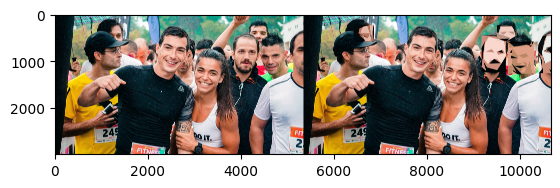

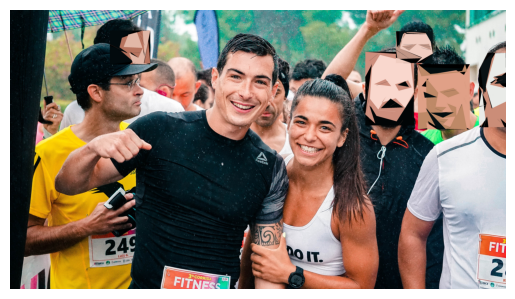

In [144]:
driver(file_args)

In [90]:
file_args

In [148]:
original = cv2.imread("/Users/aseem/Downloads/final_survey/original.png")
img_1 = cv2.imread("/Users/aseem/Downloads/final_survey/1.png")
img_2 = cv2.imread("/Users/aseem/Downloads/final_survey/2.png")
img_3 = cv2.imread("/Users/aseem/Downloads/final_survey/3.png")

In [155]:
img_1.shape

(703, 703, 3)

In [156]:
original.shape


(703, 703, 3)

In [157]:
img_2.shape

(703, 703, 3)

In [158]:
img_3.shape

(703, 698, 3)

In [154]:
dim = 703
def resize_image(im, dim):
    return cv2.resize(im, (dim,dim))

original = resize_image(original,dim)
img_1 = resize_image(img_1, dim)
img_2 = resize_image(img_2, dim)
img_3 = resize_image(im)

In [163]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
from PIL import Image

org = Image.open("/Users/aseem/Downloads/final_survey/original.png")
im1 = Image.open("/Users/aseem/Downloads/final_survey/1.png")
im2 = Image.open("/Users/aseem/Downloads/final_survey/2.png")
im3 = Image.open("/Users/aseem/Downloads/final_survey/3.png")

In [168]:
org.size

(703, 703)

In [167]:
org = org.resize((dim,dim))

In [169]:
im1 = im1.resize((dim,dim))
im2 = im2.resize((dim,dim))
im3 = im3.resize((dim,dim))

In [177]:
fig = plt.figure(figsize=(4., 4.))

<Figure size 400x400 with 0 Axes>

In [178]:
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

In [190]:
for ax, im in zip(grid, [original, img_1, img_2, img_3]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    plt.show()
plt.show()

In [180]:
grid

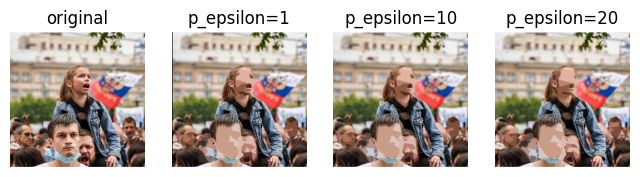

In [210]:
plt.figure(figsize=(8,20))
plt.subplot(1,4,1)
plt.axis('off')
plt.imshow(org)
plt.title('original')

plt.subplot(1,4,2)
plt.axis('off')
plt.imshow(im1)
plt.title('p_epsilon=1')

plt.subplot(1,4,3)
plt.axis('off')
plt.imshow(im2)
plt.title('p_epsilon=10')

plt.subplot(1,4,4)
plt.axis('off')
plt.imshow(im3)
plt.title('p_epsilon=20')

plt.savefig('grid.png', transparent=True)